In [29]:
# Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import itertools
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
df = pd.read_csv("/content/retail_sales_data.csv")
# Preview the first five records
df.head()

,date,store_id,category,weather,promotion,special_event,dominant_age_group,num_customers,total_sales,online_sales,in_store_sales,avg_transaction,return_rate
0,2023-01-01,store_1,Electronics,Sunny,NaN,False,25-34,137.0,1409.76,430.08,979.68,10.29,0.0453
1,2023-01-01,store_1,Clothing,Rainy,Discount,False,55+,116.0,1612.79,1238.71,374.07,13.90,0.0407
2,2023-01-01,store_1,Groceries,Sunny,Seasonal,False,18-24,120.0,1307.37,168.46,1138.92,10.89,0.0793
3,2023-01-01,store_1,Home Goods,Sunny,Discount,False,55+,132.0,1756.65,220.98,1535.66,13.31,0.0442
4,2023-01-01,store_1,Beauty,Sunny,Seasonal,False,55+,120.0,1764.91,686.24,1078.67,14.71,0.0234


In [3]:
# Getting more information on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                18250 non-null  object 
 1   store_id            18250 non-null  object 
 2   category            18250 non-null  object 
 3   weather             17904 non-null  object 
 4   promotion           14369 non-null  object 
 5   special_event       17868 non-null  object 
 6   dominant_age_group  17862 non-null  object 
 7   num_customers       17852 non-null  float64
 8   total_sales         17892 non-null  float64
 9   online_sales        17896 non-null  float64
 10  in_store_sales      17862 non-null  float64
 11  avg_transaction     17876 non-null  float64
 12  return_rate         17893 non-null  float64
dtypes: float64(6), object(7)
memory usage: 1.8+ MB


There are missing values which will need to be handled and variables to be converted to correct format for analysis and  forecasting

# Data Cleaning

In [4]:
# Checking for missing values
print("Missing Values in DataFrame:")
print(df.isnull().sum())

Missing Values in DataFrame:
date                     0
store_id                 0
category                 0
weather                346
promotion             3881
special_event          382
dominant_age_group     388
num_customers          398
total_sales            358
online_sales           354
in_store_sales         388
avg_transaction        374
return_rate            357
dtype: int64


In [5]:
# Handling missing values
# 1. Categorical columns

categorical_cols = ['weather','promotion', 'special_event', 'dominant_age_group']

# Filling missing values with mode for each categorical column
for col in categorical_cols:
    mode_value = df[col].mode().iloc[0]
    df[col] = df[col].fillna(mode_value)

# 2. Numeric columns

for col in ['num_customers','total_sales', 'online_sales', 'in_store_sales', 'avg_transaction', 'return_rate']:
    df[col] = df[col].fillna(df[col].mean())


# Verifying whether the missing values have been handled
print(df.isnull().sum())

date                  0
store_id              0
category              0
weather               0
promotion             0
special_event         0
dominant_age_group    0
num_customers         0
total_sales           0
online_sales          0
in_store_sales        0
avg_transaction       0
return_rate           0
dtype: int64


There are no missing values in the data

# Exploratory Data Analysis

## 1. Summary Statistics

In [6]:
print(df.describe())

       num_customers   total_sales  online_sales  in_store_sales  \
count   18250.000000  18250.000000  18250.000000    18250.000000   
mean      106.242382   1311.541712    526.816265      785.157977   
std        24.080939    414.262551    320.485217      366.751246   
min        51.000000    250.010000      2.000000       13.260000   
25%        90.000000   1021.745000    290.207500      521.640000   
50%       103.000000   1267.240000    477.585000      746.090000   
75%       118.000000   1531.377500    696.367500      991.282500   
max       285.000000   4202.360000   3371.680000     3178.170000   

       avg_transaction   return_rate  
count     18250.000000  18250.000000  
mean         12.482732      0.049979  
std           3.277884      0.019844  
min           2.620000     -0.026900  
25%          10.170000      0.036725  
50%          12.290000      0.049979  
75%          14.490000      0.063100  
max          27.860000      0.136600  


The number of customers per transaction is relatively consistent but shows moderate variation. The upper range indicates occasional transactions with a much larger customer base, which could be indicative of special events or promotions.



Total Sales are generally higher in-store than online, but both channels show significant variability. This suggests that while both sales channels contribute to overall revenue, in-store purchases might drive higher value transactions. However, online sales are also substantial, especially with the largest online transaction being over 3,371 units.

The mean sales are higher for in-store sales, but both channels show similar medians and IQRs, which suggests that online sales are growing steadily but in-store sales dominate overall sales.



The average transaction size (12.48 units) is relatively consistent, with a slight increase in the upper percentiles, indicating occasional bulk transactions. This could be driven by wholesale purchases or high-ticket items.

## 2. Correlation

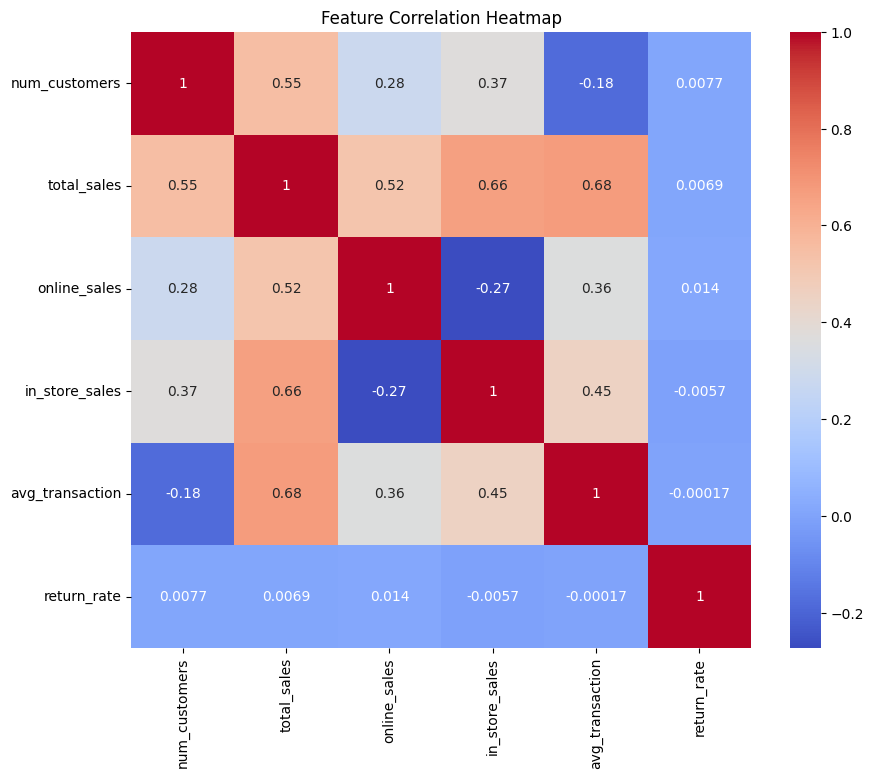

In [7]:
# Heatmap to analyze relationships between numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(df[['num_customers', 'total_sales', 'online_sales', 'in_store_sales', 'avg_transaction', 'return_rate']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

There are quite a number of positive correlation among features, implying they influence each other and the total sales. A positive correlation implies that as one variable increases, it influences another to increase while negative correlation suggests a decrease in a variable when another increases.




 There is no multicollinearity observed among the independent features.



The variable that influences total sales in this case is the average transaction. An increase in average transaction causes the total sales to increase by 68%.

## 3. Total Sales Trend Over Time

In [8]:
df['date'] = pd.to_datetime(df['date'])  # Converting 'date' column to datetime

# Set the 'date' column as the DataFrame index
df.set_index('date', inplace=True)

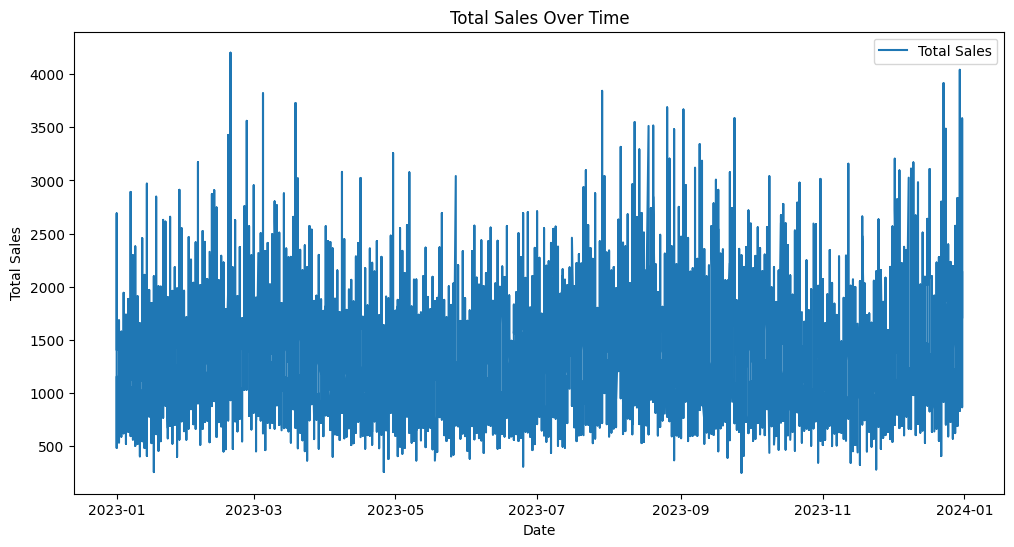

In [9]:
# Plot total_sales over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['total_sales'], label='Total Sales')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

The plot shows monthly seasonality with an anomalous value between January and March.

The total sales shoot up and down across the entire year which suggests that they significantly fluctuate on a daily basis. An example of this is when
some days exceed 3,500 units while others drop below 500 units.  This implies the possibility of irregular customer behavior such as impulse buying or even event-driven sales.





The plot gives insight into the type of business:



1.  Has irregular customer behavior such as impulse buying or event-driven sales.

2.   Relies on campaigns or flash sales.

3. Is sensitive to external variables e.g. holidays, paydays, shipping delays or promotions.



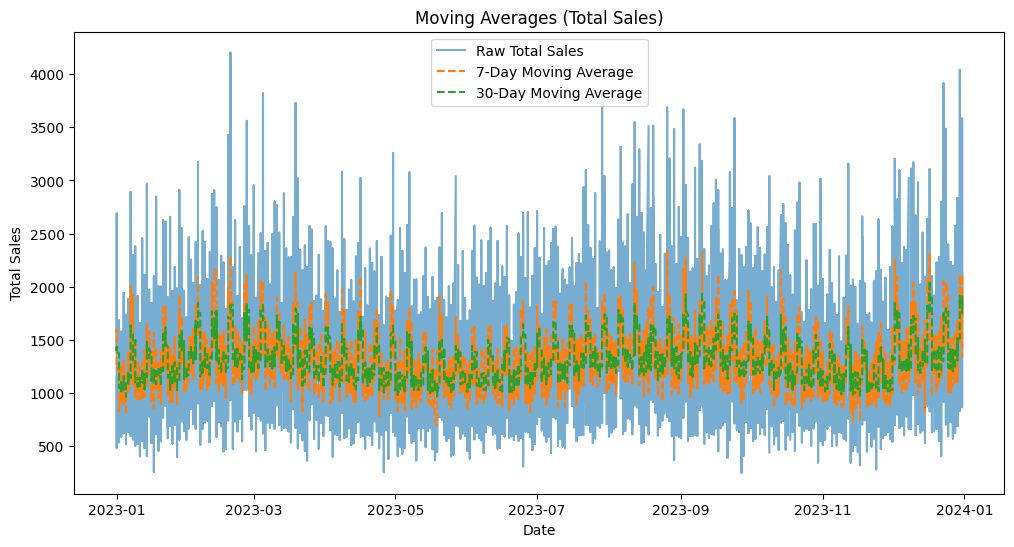

In [10]:
# Adding moving averages for total_sales to observe short-term behavior
df['7_day_MA'] = df['total_sales'].rolling(window=7).mean()
df['30_day_MA'] = df['total_sales'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['total_sales'], label='Raw Total Sales', alpha=0.6)
plt.plot(df.index, df['7_day_MA'], label='7-Day Moving Average', linestyle='--')
plt.plot(df.index, df['30_day_MA'], label='30-Day Moving Average', linestyle='--')
plt.title('Moving Averages (Total Sales)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

The 7-day MA smooths these spikes showing short-term behavior. The wave-like rhythm observed indicates weekly cyclic trends  for example if there are higher sales on weekends or Mondays. In Feb–April and Sept–Dec, the 7-day MA slightly rises which shows mini growth cycles.


Monthly Trend gives a clear view of broader trends. Small rise in early 2023 (Feb–April) can be observed with a drop around mid-year (June–July)which could be because of seasonal dips or stock issues. There is a steady recovery and upward trend toward end of year which could be attributed to holiday season or year-end promotions.


There are also recurring sales peaks throughout the year implying seasonality.


March–April, September and December exhibit Higher variability in sales suggesting these periods are commercially important (e.g., new launches, back-to-school, Black Friday, holiday shopping).

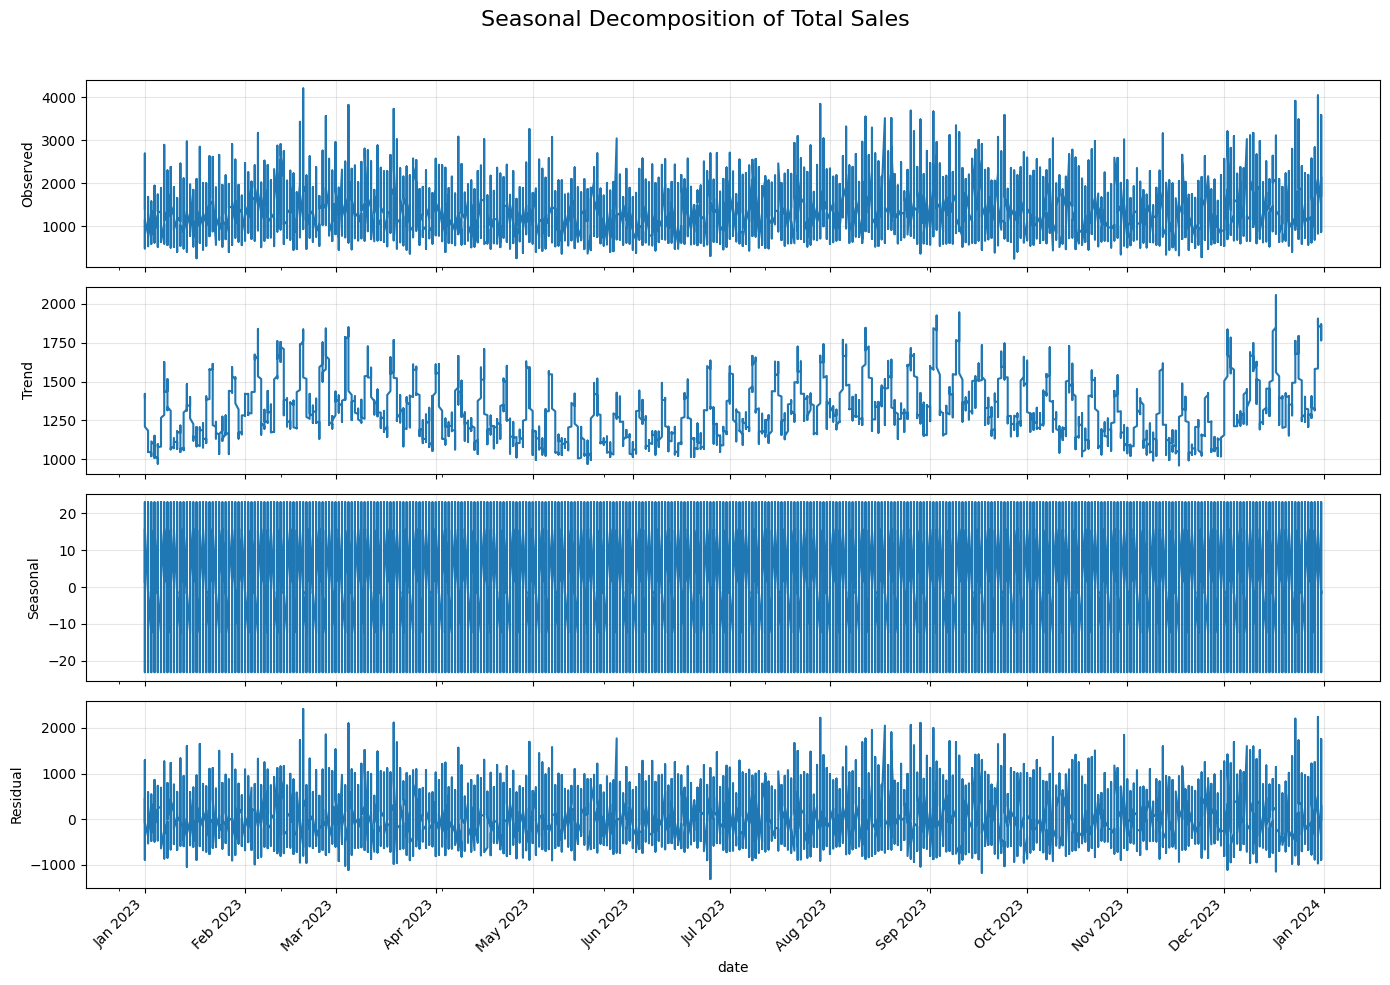

In [11]:
#  Decomposing the series
decomp = seasonal_decompose(df['total_sales'], model='additive', period=30)

# Preparing a 4‐panel plot
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Seasonal Decomposition of Total Sales', fontsize=16)

# Plotting each component
decomp.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decomp.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomp.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomp.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

# 4. Improve x‐axis date formatting
# Use monthly locators & show month abbreviation+year
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.grid(True, alpha=0.3)

# 5. Rotate & align labels
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')

# 6. Tight layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


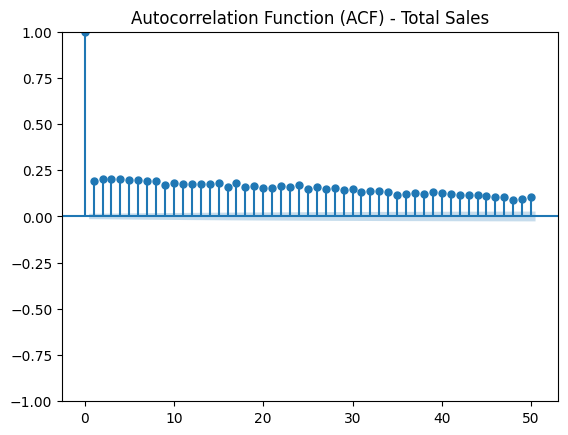

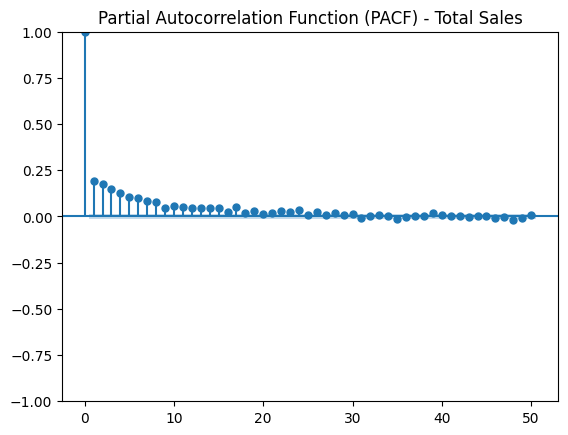

In [12]:
# Autocorrelation and partial autocorrelation plots for total_sales
plot_acf(df['total_sales'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF) - Total Sales')
plt.show()

plot_pacf(df['total_sales'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF) - Total Sales')
plt.show()




ACF of total sales shows slow decay in autocorrelations, indicating non-stationarity and a strong trend component. Notice spikes at lags around 7–8 and 30 days, hinting at weekly and monthly seasonality.


PACF of total Sales shows correlation of sales with past values at each lag after removing correlations explained by shorter lags.
A significant spike is observed at lag 1 (indicating an AR(1) effect) and smaller significant spikes at seasonal lags (around 7 and 30). After lag 1, the partial autocorrelations drop off, which suggests a simple autoregressive structure once trend and seasonality are accounted for.

## 4. Distribution of Total Sales

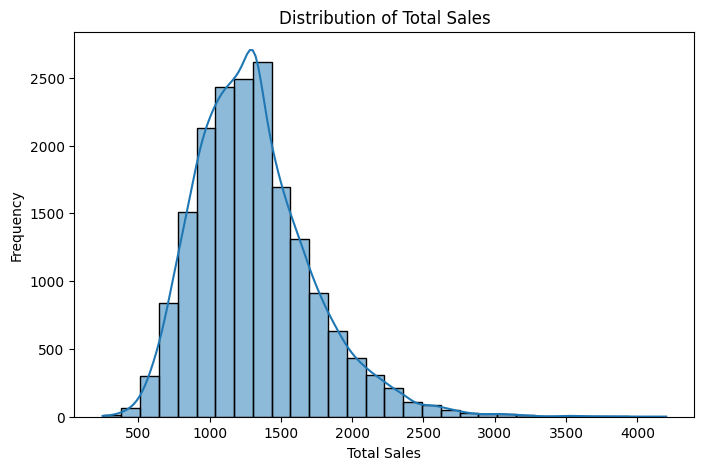

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df['total_sales'], kde=True, bins=30)
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()

 The highest frequency of sales is observed between 1000 and 1500. This indicates that most of the sales fall within this range, meaning the majority of the products sold are in this sales bracket, giveing an indication of where the bulk of your revenue is coming from.
This could suggest that the most common price points or product categories tend to cluster around this range. For instance, certain product categories such as  consumer electronics might dominate sales, and their prices often fall between 1000–1500. If promotions or discounts are often applied to products in this range, it could further explain the high frequency.


The distribution curve has a long tail extending towards the higher sales values (towards 4000), suggesting that while most sales occur at lower values (between 1000–1500), there are a few outliers (products that sold very well, possibly due to one-time promotions or exceptional products).
This is common in retail data, where most sales transactions are moderate, but a small number of high-value sales (e.g., luxury items or high-demand products) can skew the data towards the right.
This could indicate that products that would fall into these extremes (very low-priced or very expensive items) are not as popular.
It could also mean very cheap products are underperforming or very expensive products are not being sold as much, or are perhaps less accessible to the customer base.


Understanding that most of the sales come from the 1000–1500 range could help in pricing strategies, targeted promotions, and stock management. If this range represents the "sweet spot" for the product offerings, focusing more on products within this price range, or promoting similar items more heavily to increase sales volume will be approppriate.

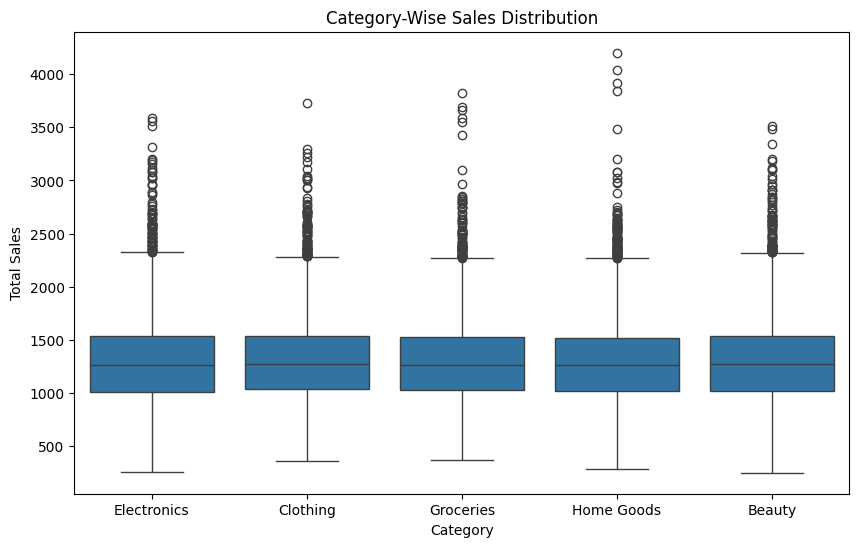

In [14]:
# Boxplot by category
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='total_sales', data=df)
plt.title('Category-Wise Sales Distribution')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.show()

All categories show similar medians and IQRs indicating that the sales performance is quite steady. This might be a good sign of market equilibrium where no category is out-performing or under-performing dramatically.


The higher outliers in the "Home Goods" category suggest that there are occasional extreme spikes in sales for this category. These could be due to special promotions, seasonal demand, or product releases.

# Feature Engineering

##  1. Temporal Features

In [15]:
# Now you can access datetime-specific attributes
df['day_of_week'] = df.index.dayofweek  # Day of the week (0 = Monday, 6 = Sunday)
df['month'] = df.index.month            # Month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Is weekend (binary feature)
# Quarter
df['quarter'] = df.index.quarter

## 2. Lag Features

In [16]:
# Creating lag features for total_sales (e.g., 1-day, 7-day, 14-day lag)
df['lag_1'] = df['total_sales'].shift(1)
df['lag_7'] = df['total_sales'].shift(7)
df['lag_14'] = df['total_sales'].shift(14)

## 3. Rolling Statistics

In [17]:
# Rolling mean for the last 7 days and 30 days
df['rolling_mean_7'] = df['total_sales'].rolling(window=7).mean()
df['rolling_mean_30'] = df['total_sales'].rolling(window=30).mean()
# Rolling standard deviation
df['rolling_std_7'] = df['total_sales'].rolling(window=7).std()

## 4. Event-Based Features

In [18]:
# Encode 'special_event' as a binary feature
df['special_event_binary'] = df['special_event'].apply(lambda x: 1 if x else 0)
# Promotion intensity (e.g., one-hot encode promotions or count active promotions)
df = pd.get_dummies(df, columns=['promotion'], prefix='promo')

## 5. Sales Proportion Features

In [19]:
# Online vs. total sales ratio
df['online_to_total_ratio'] = df['online_sales'] / df['total_sales']
# In-store vs. total sales ratio
df['in_store_to_total_ratio'] = df['in_store_sales'] / df['total_sales']

## 6. Feature Transformation

In [20]:
# Log transformation of total_sales to reduce skewness
df['log_total_sales'] = np.log1p(df['total_sales'])

# Check the resulting dataset with engineered features
print(df.head())
# Drop rows with NaN values introduced by lag/rolling features
df.dropna(inplace=True)

           store_id     category weather  special_event dominant_age_group  \
date                                                                         
2023-01-01  store_1  Electronics   Sunny          False              25-34   
2023-01-01  store_1     Clothing   Rainy          False                55+   
2023-01-01  store_1    Groceries   Sunny          False              18-24   
2023-01-01  store_1   Home Goods   Sunny          False                55+   
2023-01-01  store_1       Beauty   Sunny          False                55+   

            num_customers  total_sales  online_sales  in_store_sales  \
date                                                                   
2023-01-01          137.0      1409.76        430.08          979.68   
2023-01-01          116.0      1612.79       1238.71          374.07   
2023-01-01          120.0      1307.37        168.46         1138.92   
2023-01-01          132.0      1756.65        220.98         1535.66   
2023-01-01          1

# Preparing the data for modeling

In [21]:
# 1. Encoding Categorical Variables
# Selecting categorical columns
# Defining categorical columns

categorical_cols = ['category', 'weather', 'dominant_age_group', 'special_event',
                    'promo_BOGO', 'promo_Discount', 'promo_Flash Sale', 'promo_Seasonal']

# One-hot encoding for categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = encoder.fit_transform(df[categorical_cols])

# Converting encoded columns back to DataFrame and add to the original dataset
encoded_cols_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
df = pd.concat([df, encoded_cols_df], axis=1)

# Dropping original categorical columns after encoding
df.drop(columns=categorical_cols, inplace=True)



# 2. Preparing Features and Target for Modeling
# Define the target variable
target = 'log_total_sales'

# Excluding the target variable and ID column from features
features = df.drop(columns=[target, 'store_id', "total_sales"])


# Defining feature matrix X and target vector y
X = features
y = df[target]

# 3. Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scaling Data
# Initializing the scaler
scaler = StandardScaler()

# Scaling the training and testing data
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test = scaler.transform(X_test)        # Transform testing data using the same scaler

# Verify scaling
print("Feature scaling applied successfully. Here is a preview of the scaled training data:")
print(X_train[:5])  # Display the first 5 rows of scaled training data


# Summary of prepared data
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)


Feature scaling applied successfully. Here is a preview of the scaled training data:
[[-0.3403933  -0.13466441  0.58167923  0.79997027  1.57025935 -0.65187645
  -0.5467179   0.4963566   0.13512989 -0.63356429  0.43612061 -0.39349427
  -0.70929308 -1.35671155 -0.65187645 -0.5467179  -1.07797637 -0.22778747
  -0.38069931  0.36418064 -0.49837007  1.97429721 -0.50008576 -0.49815553
  -0.49686786  2.03594595 -0.49461277 -0.49879911 -0.52920337 -0.48600113
  -0.49418298 -0.48589327 -0.48470637 -0.49869186  1.86494874  0.22778747
  -0.22778747 -2.0222229   2.0222229   0.49127977 -0.49127977  0.83963965
  -0.83963965  0.49310815 -0.49310815]
 [ 0.4912214   0.59754708  1.3570234   1.35351616  1.16733473  1.63933709
   1.78096925  1.49717191  1.00447811  1.57837178  1.3307018   1.84427449
   0.78558622  1.45629248  1.63933709  1.78096925  0.29250356 -0.22778747
  -0.21724189  0.20281386  2.00654103 -0.50650935 -0.50008576 -0.49815553
  -0.49686786 -0.49117218  2.02178364 -0.49879911 -0.52920337 

# Sales Forecasting

In [22]:
# Model training for forecasting
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
# Future dates
future_dates = pd.date_range(start="2024-01-01", periods=14, freq='D')
stores = df['store_id'].unique()
categories = ['Beauty', 'Clothing', 'Electronics', 'Groceries', 'Home Goods']
combos = list(itertools.product(stores, categories))

future_rows = []

# Calculating dynamic features for the future using the last available value
for store, cat in combos:
    for dt in future_dates:
        # Get previous sales values for lags
        lag_1 = df.loc[(df['store_id'] == store) & (df.index == dt - pd.Timedelta(days=1)), 'total_sales'].values[0] if not df.loc[(df['store_id'] == store) & (df.index == dt - pd.Timedelta(days=1))].empty else 0
        lag_7 = df.loc[(df['store_id'] == store) & (df.index == dt - pd.Timedelta(days=7)), 'total_sales'].values[0] if not df.loc[(df['store_id'] == store) & (df.index == dt - pd.Timedelta(days=7))].empty else 0
        lag_14 = df.loc[(df['store_id'] == store) & (df.index == dt - pd.Timedelta(days=14)), 'total_sales'].values[0] if not df.loc[(df['store_id'] == store) & (df.index == dt - pd.Timedelta(days=14))].empty else 0

        # Rolling statistics
        rolling_mean_7 = df.loc[(df['store_id'] == store) & (df.index <= dt)].tail(7)['total_sales'].mean() if (df.loc[(df['store_id'] == store) & (df.index <= dt)].shape[0] >= 7) else 0
        rolling_std_7 = df.loc[(df['store_id'] == store) & (df.index <= dt)].tail(7)['total_sales'].std() if (df.loc[(df['store_id'] == store) & (df.index <= dt)].shape[0] >= 7) else 0

        # Constructing row with dynamic features
        row = {
            'store_id': store,
            'day_of_week': dt.weekday(),
            'month': dt.month,
            'is_weekend': 1 if dt.weekday() >= 5 else 0,
            'quarter': (dt.month-1)//3 + 1,
            'special_event_binary': 0,
            'promo_BOGO_False': 1,
            'promo_BOGO_True': 0,
            'promo_Discount_False': 1,
            'promo_Discount_True': 0,
            'promo_Flash Sale_False': 1,
            'promo_Flash Sale_True': 0,
            'promo_Seasonal_False': 1,
            'promo_Seasonal_True': 0,
            'weather_Sunny': 1,
            'weather_Cloudy': 0,
            'weather_Rainy': 0,
            'weather_Snowy': 0,
            'weather_Windy': 0,
            'dominant_age_group_25-34': 1,
            'dominant_age_group_18-24': 0,
            'dominant_age_group_35-44': 0,
            'dominant_age_group_45-54': 0,
            'dominant_age_group_55+': 0,
            'online_to_total_ratio': 0.3,
            'in_store_to_total_ratio': 0.7,
            'lag_1': lag_1,
            'lag_7': lag_7,
            'lag_14': lag_14,
            'rolling_mean_7': rolling_mean_7,
            'rolling_mean_30': 0,
            'rolling_std_7': rolling_std_7,
            'num_customers': 100,
            'online_sales': 1000,
            'in_store_sales': 2000,
            'avg_transaction': 30,
            'return_rate': 0.05,
            '7_day_MA': 3000,
            '30_day_MA': 3200,
        }

        # One-hot encode category
        for c in categories:
            row[f'category_{c}'] = 1 if cat == c else 0

        future_rows.append(row)

# Building future DataFrame
future_df = pd.DataFrame(future_rows)

# Adding date separately
future_df['date'] = np.tile(future_dates, len(combos))

# Saving store_id separately for final output
future_df['store_id'] = np.repeat([store for store, _ in combos], len(future_dates))

# Dropping 'store_id' because model was trained without it
X_future = future_df.drop(columns=['store_id', 'date'])

# Matching features with the model's training set
feature_cols = list(X.columns)
for col in feature_cols:
    if col not in X_future.columns:
        X_future[col] = 0  # adding missing columns
X_future = X_future[feature_cols]  # reorder exactly

# Scaling
X_future_scaled = scaler.transform(X_future)

# Prediction
future_log_preds = model.predict(X_future_scaled)
future_preds = np.expm1(future_log_preds)  # inverse log1p transformation

# Final forecast DataFrame
final_forecast = pd.DataFrame({
    'store_id': future_df['store_id'],
    'date': future_df['date'],
    'forecast_total_sales': future_preds
})

# Output the final forecast
print(final_forecast.head(10))


  store_id       date  forecast_total_sales
0  store_6 2024-01-01           2262.813158
1  store_6 2024-01-02           2167.388335
2  store_6 2024-01-03           2099.068261
3  store_6 2024-01-04           2160.609452
4  store_6 2024-01-05           2154.437725
5  store_6 2024-01-06           2173.825122
6  store_6 2024-01-07           2174.680096
7  store_6 2024-01-08           1978.901527
8  store_6 2024-01-09           1978.594778
9  store_6 2024-01-10           1977.153870


In [24]:
# Predict log-transformed sales
y_test_pred_log = model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

# Inverse-transform true values
y_test_actual = np.expm1(y_test.values)

# Evaluation metrics
mae = mean_absolute_error(y_test_actual, y_test_pred)
mse = mean_squared_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)

# MAPE: ignoring zero actuals
nonzero_idx = y_test_actual != 0
mape = np.mean(np.abs((y_test_actual[nonzero_idx] - y_test_pred[nonzero_idx]) / y_test_actual[nonzero_idx])) * 100
accuracy = 100 - mape


# Printing
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test Accuracy: {accuracy:.2f}%")


Test MAE: 28.28
Test RMSE: 84.09
Test MAPE: 2.13%
Test Accuracy: 97.87%


The model generalizes extremely well on unseen test data.

Errors are minimal because there are no large mistakes or outliers affecting the results badly.



## Feature Importance

Top 10 Most Important Features for Sales Prediction:
                   feature  importance
0          avg_transaction    0.579260
1            num_customers    0.382300
2           in_store_sales    0.008635
3             online_sales    0.004698
4  in_store_to_total_ratio    0.004234
5            rolling_std_7    0.003023
6    online_to_total_ratio    0.002637
7                    lag_7    0.001831
8           rolling_mean_7    0.001450
9                   lag_14    0.001376


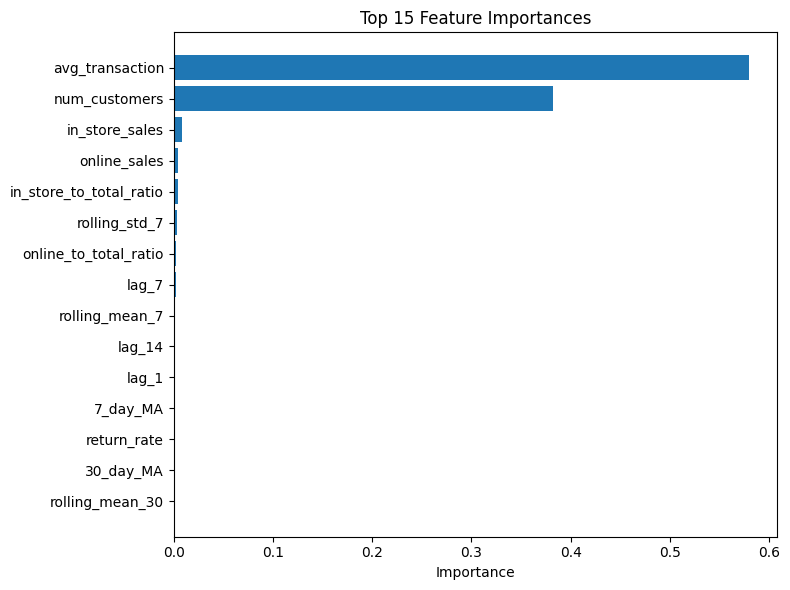

In [25]:
# Getting feature importances from the trained model
importances = model.feature_importances_

# Building a DataFrame for easy sorting/plotting
feat_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
})

# Sorting in descending order
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Print top 10 features
print("Top 10 Most Important Features for Sales Prediction:")
print(feat_imp_df.head(10))

# Plotting the top 15 features
plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df['feature'].head(15)[::-1], feat_imp_df['importance'].head(15)[::-1])
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


The feature avg_transaction stands out as the most important predictor for sales. This suggests that the average value of transactions is a key driver of overall sales performance. Stores with higher average transaction values are likely contributing significantly to the sales, indicating that customer behavior and purchasing power (e.g., buying more expensive items or purchasing in bulk) play a major role in the sales predictions.

The number of customers is also a crucial factor in predicting sales. This reflects the basic premise that higher foot traffic or more customers visiting a store correlates with higher sales. The relationship between customer volume and total sales is a significant factor, so stores with more customers are expected to generate higher sales figures, as customer presence directly impacts the amount of sales made.

In-Store Sales (0.008635): While in_store_sales is still a relevant feature, its relatively low importance suggests that in-store sales alone might not be as significant in predicting future sales, especially when combined with other features like average transaction and number of customers. This might indicate that the model is capturing a broader picture with other features like customer behavior and promotions, making individual in-store sales figures less critical in isolation.

Online Sales (0.004698): Similar to in-store sales, online_sales has a lower importance score. This might reflect the store’s sales environment, where physical store metrics (number of customers and average transaction) are more predictive than online sales figures. However, the relatively small importance score also suggests that online sales, while relevant, might not be as influential in the current model.

In-Store to Total Ratio (0.004234): The in-store to total ratio represents the proportion of sales made in-store versus online. Although important, its relatively low impact indicates that while the distribution between in-store and online sales is a factor, it’s secondary to direct sales figures and customer behavior.

Rolling Standard Deviation of 7 Days (0.003023): The rolling standard deviation over the last 7 days shows the variability in sales over the past week. While this feature provides insights into sales volatility, its lower importance suggests that sales predictions are more influenced by customer behavior and average transactions than short-term fluctuations in sales.

# Customer Segmentation

## Clustering Using K-Means

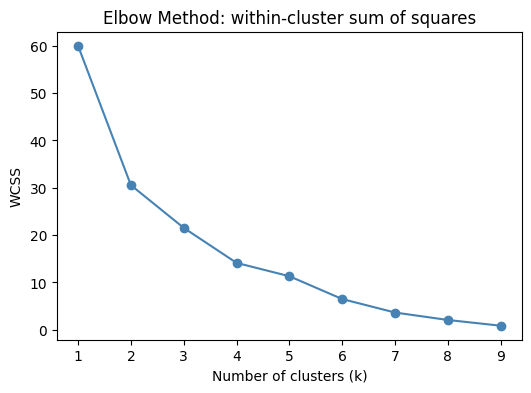

In [30]:
# Aggregating at store level
numeric_aggs = {
    'total_sales': ['mean', 'sum'],
    'num_customers': 'mean',
    'avg_transaction': 'mean',
    'online_to_total_ratio': 'mean',
    'return_rate': 'mean'
}
store_features = df.groupby('store_id').agg(numeric_aggs)

# Flattening multi‐level columns
store_features.columns = [
    f"{feat}_{stat}"
    for feat, stat in store_features.columns
]
store_features = store_features.reset_index().rename(columns={
    'total_sales_mean':   'avg_daily_sales',
    'total_sales_sum':    'total_sales',
    'num_customers_mean': 'avg_num_customers',
    'avg_transaction_mean':'avg_transaction_value',
    'online_to_total_ratio_mean':'online_sales_ratio',
    'return_rate_mean':   'avg_return_rate'
})

# Scaling features
features = store_features.drop(columns='store_id')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Elbow Method for k
wcss = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1,10), wcss, 'o-', color='steelblue')
plt.title('Elbow Method: within-cluster sum of squares')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()



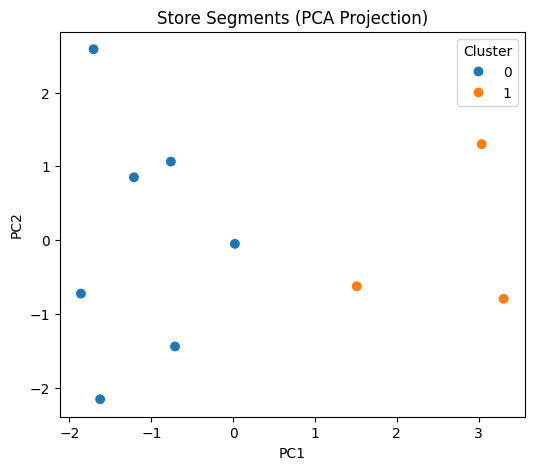

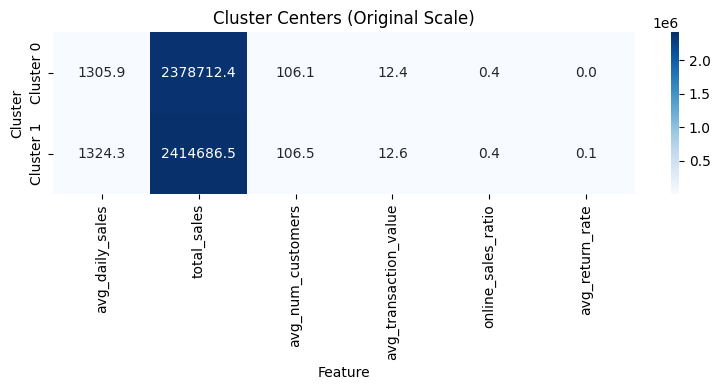

In [32]:
# Fitting final KMeans
k_final = 2
km = KMeans(n_clusters=k_final, random_state=42, n_init='auto')
store_features['cluster'] = km.fit_predict(X_scaled)

# PCA scatter plot of clusters
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
plt.figure(figsize=(6,5))
sns.scatterplot(x=coords[:,0], y=coords[:,1],
                hue=store_features['cluster'],
                palette='tab10', s=60)
plt.title('Store Segments (PCA Projection)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

# Cluster-center heatmap
centers = scaler.inverse_transform(km.cluster_centers_)
center_df = pd.DataFrame(centers, columns=features.columns)
center_df.index = [f'Cluster {i}' for i in range(k_final)]

plt.figure(figsize=(8,4))
sns.heatmap(center_df, annot=True, fmt=".1f", cmap='Blues')
plt.title('Cluster Centers (Original Scale)')
plt.xlabel('Feature'); plt.ylabel('Cluster')
plt.tight_layout()
plt.show()



## Actionable insights for each segment

In [34]:
# Summarizing clusters & actionable insights
summary = store_features.groupby('cluster')[features.columns].mean()
print("Cluster Summary:\n", summary, "\n")

# Comparing Cluster 0 vs Cluster 1 directly
cluster_0 = summary.loc[0]
cluster_1 = summary.loc[1]


Cluster Summary:
          avg_daily_sales   total_sales  avg_num_customers  \
cluster                                                     
0            1305.861245  2.378712e+06         106.109490   
1            1324.332249  2.414686e+06         106.528664   

         avg_transaction_value  online_sales_ratio  avg_return_rate  
cluster                                                              
0                    12.438062            0.402886         0.049803  
1                    12.583738            0.400518         0.050371   



For Segment 0 (slightly lower daily sales, slightly better online ratio):
Focusing on boosting in-store upselling strategies and enhancing the e-commerce experience to push online sales even further will capitalize on the existing slight advantage.

For Segment 1 (higher daily sales, slightly higher return rates):
Maintaining strong in-store performance, but investigating reasons for returns will reduce potential revenue leakage. Targeted product quality reviews or better pre-purchase information online may be of great help.

For Both Segments:
Given their balanced online and in-store sales mix, a hybrid marketing approach (omnichannel promotions) would suit both segments well.

## Store-specific strategies

Segment 0 Stores (avg_daily_sales ≈ $1,305, slightly higher online sales ratio, lower return rate):

Enhancing Online Sales:
Since online sales are relatively stronger, investing more in digital marketing — SEO, social ads, personalized email campaigns will be appropriate.

In-Store Cross-Selling:
Improving in-store conversion by training staff on upselling and bundling promotions (e.g., "Buy X, get Y at 20% off") will be appropriate.

Exclusive Online Offers:
The best idea is to launch web-only promotions to reinforce the slightly higher online presence and drive repeat customers.

Customer Loyalty Program:
Introducing loyalty rewards for online and in-store purchases to boost retention and increase basket size will be good for the store.

Segment 1 Stores (avg_daily_sales ≈ $1,324, slightly higher return rate):

Improving Product Information:
It will be best to address the slightly higher return rate by improving product descriptions, adding real customer reviews, and better sizing/guidance online and in-store.

Quality Assurance:
Implementing a post-purchase survey to detect early product or service dissatisfaction and reduce future returns will be good for the store.

Leveraging In-Store Strength:
Organizing local events (e.g., community days, mini pop-ups) to capitalize on the strong physical store traffic will be a good idea for the well-being of the store.

Premium Product Strategy:
Since average transaction value is slightly higher, expanding premium offerings or introduce tiered pricing strategies will maximize revenue from higher-spending customers.